# Install and Import Dependencies

In [ ]:
!pip install datasets transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.0 MB/s 
     |████████████████████████████████| 4.2 MB 69.3 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 212 kB 55.8 MB/s 
     |████████████████████████████████| 140 kB 66.6 MB/s 
     |████████████████████████████████| 1.1 MB 53.9 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 127 kB 71.6 MB/s 
     |████████████████████████████████| 144 kB 73.5 MB/s 
     |████████████████████████████████| 271 kB 53.0 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 39.9 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 1.2 MB 39.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling

In [ ]:
# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Model and data handling
import torch
from transformers import DistilBertForSequenceClassification, AutoTokenizer, Trainer
from datasets import load_dataset

# Load Evaluation Dataset

In [ ]:
fpath = "/content/drive/MyDrive/Colab Notebooks/Rewire/"
data_files = {'test': fpath + "data/test.csv"}
dataset = load_dataset('csv', data_files=data_files)
dataset = dataset.rename_column("class", "labels")

Using custom data configuration default-0212003e1b95357f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0212003e1b95357f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['labels', 'tweet'],
        num_rows: 2479
    })
})

# Load Model and Tokeniser

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(fpath + "model/final/distilBERT_hatespeech")
tokenizer = AutoTokenizer.from_pretrained(fpath + "model/final/tokenizer")

# Make Predictions

In [ ]:
# Tokenize dataset
def tokenize(batch):
  return tokenizer(batch["tweet"], padding=True, truncation=True)


test_encoded = dataset["test"].map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Convert to PyTorch tensors
cols = ['input_ids', 'attention_mask', 'labels']
test_encoded.set_format(type='torch', columns=cols)

In [ ]:
# Instantiate trainer to make prediction easier
trainer = Trainer(model)

In [ ]:
# Create predictions
preds, label_ids, _ = trainer.predict(test_encoded)
pred_labels = np.argmax(preds, axis=1)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2479
  Batch size = 8


# Evaluate Performance

__Confusion Matrix__

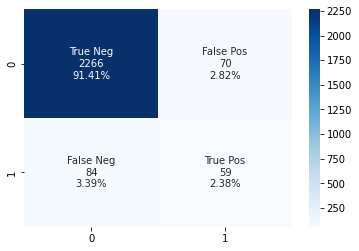

In [ ]:
# Produce confusion matrix
conf_matrix = confusion_matrix(label_ids, pred_labels)

# Create visualisation
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues')
plt.show()

+ Performance is good for the negative class but not very good for the positive class (predicting hate speech present)
+ Visualisation code for confusion matrix from Dennis T [(Medium)](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

__Classification Report__

In [ ]:
# Produce classification report
print(classification_report(label_ids, pred_labels))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2336
           1       0.46      0.41      0.43       143

    accuracy                           0.94      2479
   macro avg       0.71      0.69      0.70      2479
weighted avg       0.94      0.94      0.94      2479



+ Both precision and recall aren't great for the positive class
+ Precision is about returning more relevant results than irrelevant, i.e. trying to predict hate speech without wrongly classifying a tweet as hate speech when it is not.
+ Recall is about returning most of the relevant examples, irrespective of whether or not irrelevant examples are also returned, i.e. trying to make sure most of the hate speech tweets are predicted as hate speech.
+ The problem should be a balance of the two because you don't want to miss lots of tweets which are hate speech. But at the same time, you don't want to classify all tweets as hate speech. From the perspective of a platform, you gain a bad reputation for allowing hate speech to continue on your platform AND users might get frustrated that all their content is being classified as hate speech. Therefore, both are important.

__Error Analysis__

+ Error analysis code from [lewtun](https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb) of HuggingFace

In [ ]:
# More error analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() 
            if k in tokenizer.model_input_names}

  with torch.no_grad():
    # Forward pass
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)

    # Calculate weighted loss
    pt_class_weights = torch.FloatTensor([0.53061771, 8.66520979]).to(device)
    loss = torch.nn.functional.cross_entropy(output.logits, batch["labels"].to(device), weight=pt_class_weights, reduction="none")

  # Place outputs on CPU for compatibility with other dataset columns   
  return {"loss": loss.cpu().numpy(), 
          "predicted_label": pred_label.cpu().numpy()}

In [ ]:
loss_values = test_encoded.map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/155 [00:00<?, ?ba/s]

In [ ]:
# Convert to pandas for easily manipulation and viewing
loss_values.set_format("pandas")
cols = ["tweet", "labels", "predicted_label", "loss"]
df_test = loss_values[:][cols]

In [ ]:
# Sort test examples by largest loss
df_test.sort_values("loss", ascending=False).head(10)

,tweet,labels,predicted_label,loss
686,pantera - 5 minutes alone [URL] [MENTION] 5 mi...,1,0,40.060749
2259,ankles [EMOJI][EMOJI]“[MENTION]: “[MENTION]: h...,1,0,39.785286
610,rt [MENTION]: dead!![EMOJI]“[MENTION]: [EMOJI]...,1,0,39.685226
790,you a hoe if you crying because yo ass pregnan...,1,0,39.646015
960,rt [MENTION]: [MENTION] californias biggest re...,1,0,38.221004
1817,rt [MENTION]: im a get money nigga so da hoes ...,1,0,38.113636
2193,rt [MENTION]: niggas always wanna talk about h...,1,0,37.571571
2386,rt [MENTION]: its 2014 & you niggas still runn...,1,0,37.559311
2268,i really get upset when my lightskin friends h...,1,0,37.307163
460,rt [MENTION]: at least i say im crazy...some n...,1,0,37.081158


+ The model is least confident when predicting the positive class - there is class weighting in loss function remember

In [ ]:
# Sort test examples by smallest loss
df_test.sort_values("loss").head(10)

,tweet,labels,predicted_label,loss
1976,my dads friend was telling my dad and i about ...,0,0,0.005188
1105,trust me [HASH]> we give [HASH] its due> a hug...,0,0,0.005193
615,"rt [MENTION]: yes, the bird tweets in the morn...",0,0,0.005195
233,“[MENTION]: i couldnt hit a woman with a penis...,0,0,0.005197
440,"[HASH],[HASH],[HASH],[HASH],[HASH],[HASH], | [...",0,0,0.005212
1611,rt [MENTION]: i am nice i am humble but i will...,0,0,0.005219
925,rt [MENTION]: dont give a man the pussy until ...,0,0,0.005221
1225,sooo my first aid/cpr certification came in ha...,0,0,0.005231
2476,"when the bitch playes with your emotions, an w...",0,0,0.005233
750,mother asked what i wanted for christmas this ...,0,0,0.005235


+ The model is most confident when predicting the negative class

__Improvements:__

+ Use error analysis more to understand where the model is failing
+ Data augmentation for minority class, e.g. synonym replacement, random insertion, randomly swap words, shuffle sentences
+ Functional testing from HateCheck